# Code to download HYCOM data from ERDDAP
Author: Johanna Wren

Date: Sept 18, 2025

email: johanna.wren@noaa.gov

Description: Here is some code to access HYCOM data via erddap and subset then download the data. Becuase this version of HYCOM is on a -180/180 longitude, we have to change that to 0/360 and reorder the x-axis. I have outlined both a step by step process and at the end put it all together into a loop so you can just start that kernel and run it, or better yet, save that bit as a .py script and run and park it on a server somewhere. 

In [1]:
import xarray as xr
import netCDF4 as nc

### Access the dataset on erddap using xarray

In [2]:
myDat = xr.open_dataset('https://apdrc.soest.hawaii.edu/erddap/griddap/hawaii_soest_e9ba_92b1_0bcd')
myDat

<xarray.Dataset> Size: 341TB
Dimensions:     (time: 59168, LEV: 40, latitude: 2001, longitude: 4500)
Coordinates:
  * time        (time) datetime64[ns] 473kB 1992-10-02 ... 2012-12-31T21:00:00
  * LEV         (LEV) float64 320B 0.0 2.0 4.0 6.0 ... 2.5e+03 3e+03 4e+03 5e+03
  * latitude    (latitude) float64 16kB -80.0 -79.92 -79.84 ... 79.84 79.92 80.0
  * longitude   (longitude) float64 36kB -180.0 -179.9 -179.8 ... 179.8 179.9
Data variables:
    water_u     (time, LEV, latitude, longitude) float32 85TB ...
    water_v     (time, LEV, latitude, longitude) float32 85TB ...
    water_temp  (time, LEV, latitude, longitude) float32 85TB ...
    salinity    (time, LEV, latitude, longitude) float32 85TB ...
Attributes: (12/28)
    cdm_data_type:             Grid
    Conventions:               COARDS, CF-1.6, ACDD-1.3
    creator_email:             forum@hycom.org
    creator_name:              APDRC
    creator_type:              institution
    creator_url:               https://hycom.org/
    ...                        ...
    standard_name_vocabulary:  CF Standard Name Table v29
    summary:                   data apdrc.soest.hawaii.edu dods public ofes H...
    time_coverage_end:         2012-12-31T21:00:00Z
    time_coverage_start:       1992-10-02T00:00:00Z
    title:                     data apdrc.soest.hawaii.edu dods public ofes H...
    Westernmost_Easting:       -180.0

Then subset the dataset in time and depth and turn 180/-180 into 0-360

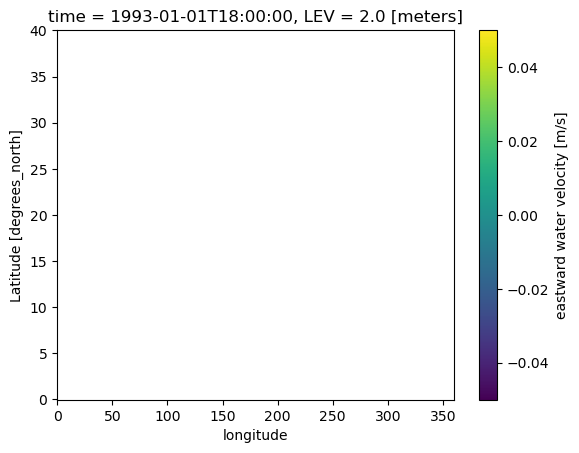

In [16]:
# subset
test = myDat[['water_u', 'water_v']].sel(time='1993-01-01T18:00:00', LEV=[2,6,20,60,250], latitude=slice(0,40))

# change from 180/-180 to 0-360 se we can crop over the dateline
test = test.assign_coords(longitude=((360 + (test.longitude % 360)) % 360))
test = test.roll(longitude=int(len(test['longitude']) / 2),roll_coords=True)

# See if it worked
test.water_u.sel(LEV=2).plot()


In [17]:
len(test)

2

Then slice out the spatial area you want

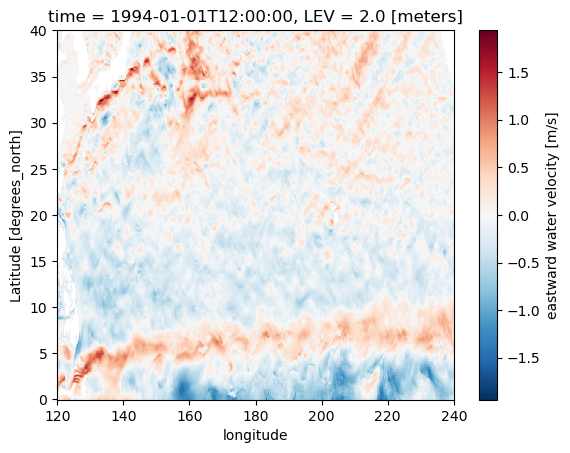

In [4]:
# Subset for the lon and lat you want
test2 = test.sel(longitude=slice(120,240))

# Just to make sure it looks right, I plotted U for 2m depth
test2.water_u.sel(LEV=2).plot()

Save the data

In [ ]:
# Save data
test2.to_netcdf('~/Desktop/HYCOMdata/testhycom2.nc')

## Here is everything above put together into a loop
I am looping over 3h increments. I found that the first day was blank so I started one day earlier than I needed, but play around with it to see what works for you. 

**CHANGE THE `range(10)` TO HOWEVER MANY FILES YOU WANT TO LOOP THROUGH**


In [ ]:
import xarray as xr
import netCDF4 as nc
from datetime import timedelta, datetime

# Load HYCOM dataset metadata
myDat = xr.open_dataset('https://apdrc.soest.hawaii.edu/erddap/griddap/hawaii_soest_e9ba_92b1_0bcd')

# Start looping through time (every 3h)
start_date = datetime(1994, 1, 1, 9, 0, 0)
for td in (start_date + timedelta(hours=3*it) for it in range(6)):  # change the range here to the number of files you want to download. One year would be 365*8 since they are 3h files, so 8 each day
    print(td)
    # subset
    test = myDat[['water_u']].sel(time=td.strftime("%Y-%m-%dT%H:%M:%S"), LEV=[250], latitude=slice(0,40))

    # change from 180/-180 to 0-360 se we can crop over the dateline
    test = test.assign_coords(longitude=((360 + (test.longitude % 360)) % 360))
    test = test.roll(longitude=int(len(test['longitude']) / 2),roll_coords=True)

    # Subset for the lon and lat you want
    test2 = test.sel(longitude=slice(120,240))

    # Renaming the depth variable becuase I really don't like LEV
    test2.rename({'LEV' : 'depth'})

    # Save data
    print('Saving file')
    test2.to_netcdf(''.join(['HYCOMdata/HYCOM_partials_', td.strftime('%Y%m%d%H'), '.nc']))


1993-01-01 09:00:00
Saving file
1993-01-01 12:00:00
Saving file
1993-01-01 15:00:00
Saving file
1993-01-01 18:00:00
Saving file
1993-01-01 21:00:00
Saving file
1993-01-02 00:00:00
Saving file


In [ ]:
#ds = xr.open_dataarray('HYCOMdata/HYCOM_partials_1993010200.nc')
#ds.plot()

# A quick check of a file using ncdump. You have to do the ! in front to tell jupyter notebook that you are typing a shell command and not a python command
# to see a variable use -v and the variable name, to see the header info use -h 
!ncdump -v water_u HYCOMdata/HYCOM_partials_1993010118.nc
# !ncdump -h HYCOMdata/HYCOM_partials_1993010200.nc

netcdf HYCOM_partials_1993010118 {
dimensions:
	LEV = 1 ;
	latitude = 501 ;
	longitude = 1501 ;
variables:
	float water_u(LEV, latitude, longitude) ;
		water_u:_FillValue = -30000.f ;
		water_u:colorBarMaximum = 0.5 ;
		water_u:colorBarMinimum = -0.5 ;
		water_u:direction = "IJKL" ;
		water_u:ioos_category = "Currents" ;
		water_u:long_name = "eastward water velocity [m/s]" ;
		water_u:standard_name = "eastward_sea_water_velocity" ;
		water_u:coordinates = "time" ;
		water_u:missing_value = -30000.f ;
	double time ;
		time:_FillValue = NaN ;
		time:_CoordinateAxisType = "Time" ;
		time:actual_range = 717984000., 1356987600. ;
		time:axis = "T" ;
		time:direction = "L" ;
		time:ioos_category = "Time" ;
		time:long_name = "Time" ;
		time:point_spacing = "even" ;
		time:standard_name = "time" ;
		time:time_origin = "01-JAN-1970 00:00:00" ;
		time:units = "seconds since 1970-01-01T00:00:00+00:00" ;
		time:calendar = "GREGORIAN" ;
	double LEV(LEV) ;
		LEV:_FillValue = NaN ;
		LEV:actual_ran